# Notebooke for Creating and Training DNN Model for PV Power Forcast

### Inhalt:
- Imports und Defindes
- Hyperparameter defins
- Data Loader
- Choose model name
- choose model Architekture
- Train and eval the model
- Test model agianst Benchmark model

In [1]:
# Importieren der Bibliotheken
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import kurtosis, skew
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.model_selection import train_test_split
from google.colab import drive

# Bibliotheken für DNN Model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

# Bibliotheken für Transferlearning Model
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16


drive.mount('/content/drive')

# Def Paths
BASE_FILE_PATH = "/content/drive/My Drive/BA"
SAVE_MODEL_PATH = "wights_and_Models/"

print("Setup complete!")


Mounted at /content/drive
Setup complete!


# Definieren Wichtiger Funktionen

In [2]:
##########################################
# Funktion für das Model Speichern/Laden #
##########################################
def save_my_model(model,folder_path, model_name=None):
    """
    Saves the trained model and its weights in the model_name Folder path.
    """
    # Erstelle einen Ordner, wenn er nicht existiert

    os.makedirs(folder_path, exist_ok=True)
    print(f"folder_path path: {folder_path}")
    weights_filename = f'weights.hdf5'
    model_filename = f'model.keras'

    # Speichere die trainierten Gewichte
    weights_path = os.path.join(folder_path, weights_filename)
    model.save_weights(weights_path)

    # Speichere das Modell an sich
    model_path = os.path.join(folder_path, model_filename)
    model.save(model_path)

    # Debugg
    print(f"weights_path: {weights_path}")
    print(f"model_path: {model_path}")
    print(f"folder_path: {folder_path}")

    return


def load_my_model(model_name=None):
    """
    Loads a previously saved model and its weights.
    """
    if model_name:
      folder_path=f"/content/drive/My Drive/BA/wights_and_Models/{model_name}"
      # Erstelle den Dateinamen basierend auf dem Modellnamen
      weights_filename = f'/weights.hdf5'
      model_filename = f'/model.keras'

      # Pfade für Gewichte und Modell
      weights_path = folder_path + weights_filename
      model_path = folder_path + model_filename

      # Lade das Modell
      loaded_model = load_model(model_path)
      loaded_model.load_weights(weights_path)

    else:
      loaded_model = None
      print("Provide Model Name!")

    return loaded_model

def get_shape(obj):
    if isinstance(obj, np.ndarray):
        return obj.shape
    elif isinstance(obj, list):
        return len(obj)
    elif isinstance(obj, dict):
        return {key: len(val) if isinstance(val, (list, np.ndarray)) else "N/A" for key, val in obj.items()}
    else:
        return "N/A"

def print_shapes(**kwargs):
    for name, value in kwargs.items():
        shape_info = get_shape(value)
        if isinstance(shape_info, dict):
            for key, length in shape_info.items():
                print(f"Variable: {name}.{key}, Length: {length}")
        else:
            print(f"Variable: {name}, Shape/Length: {shape_info}")


###################################
# Funktio für das Laden der Datem #
###################################

def load_preprocessed_data(parent_folder_path, small_dataset=True):
    """
    Lädt Daten aus Pickle-Dateien in einen Datensatz.

    Parameters:
    parent_folder_path (str): Der Pfad zum übergeordneten Ordner, der Unterordner mit Pickle-Dateien enthält.
    small_dataset (bool): True, wenn nur die Hälfte des Datensatzes geladen werden soll, andernfalls False.

    Returns:
    dict: Ein Dictionary mit den geladenen Daten.
    """
    data_set = {}

    # Durchsuche alle Unterordner des übergeordneten Ordners
    subfolders = [f for f in os.listdir(parent_folder_path) if os.path.isdir(os.path.join(parent_folder_path, f))]

    if subfolders:
        for folder_name in subfolders:
            folder_path = os.path.join(parent_folder_path, folder_name)
            load_data_from_folder(data_set, folder_path, small_dataset)
    else:
        # Wenn keine Unterordner vorhanden sind, lade Pickle-Dateien direkt aus dem Hauptordner
        load_data_from_folder(data_set, parent_folder_path, small_dataset)

    return data_set

def load_data_from_folder(data_set, folder_path, small_dataset=True):
    """
    Lädt Daten aus Pickle-Dateien in einen Datensatz.

    Parameters:
    data_set (dict): Das Dictionary, dem die geladenen Daten hinzugefügt werden.
    folder_path (str): Der Pfad zum Ordner, der Pickle-Dateien enthält.
    small_dataset (bool): True, wenn nur die Hälfte des Datensatzes geladen werden soll, andernfalls False.

    Returns:
    None
    """
    # Durchsuche den Ordner nach Pickle-Dateien
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl"):
            var_name = os.path.splitext(filename)[0]  # Entferne die Dateiendung
            file_path = os.path.join(folder_path, filename)

            # Lade die Pickle-Datei und füge sie zum Daten-Dict hinzu
            with open(file_path, 'rb') as file:
                loaded_data = pickle.load(file)

                # Reduziere die Datenmenge, wenn small_dataset True ist
                if small_dataset:
                    loaded_data = loaded_data[:len(loaded_data)//2]

                data_set[var_name] = loaded_data



###################################
# Funktion für das Model Training #
###################################

def train_my_model(model, model_name, train_input, train_labels, val_input, val_labels, early_stopping_patience=15, opti="Adam", loss_function='mean_absolute_error'):
    """
    Trains the provided model using the specified training and validation data.
    """

    # Set up paths
    save_path = os.path.join(BASE_FILE_PATH, SAVE_MODEL_PATH, model_name)
    os.makedirs(save_path, exist_ok=True)
    print(f"save path: {save_path}")

    if opti == "Adam":
         optimizer = Adam(learning_rate=hyper_params["learning_rate"])
    elif opti == "SGD":
        optimizer = SGD(learning_rate=hyper_params["learning_rate"], momentum=0.9, nesterov=True)
    else:
        raise ValueError("Ungültiger Optimierer")

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_function,
                  metrics=['mean_absolute_error','mean_squared_error'])

    # Define Callbacks
    callbacks = define_callbacks(save_path, model_name, early_stopping_patience)

    # Train the model
    history = fit_model(model, train_input, train_labels, val_input, val_labels, callbacks)

    # Save the trained model
    save_my_model(model,save_path, model_name)

    # Plotte die Trainings- und Validierungsverlustkurve
    Train_Val_loss_plot = plot_training_history(history)

    # Save model plot
    save_model_plot(model, save_path, Train_Val_loss_plot)

    return model, history

def plot_training_history(history):
    """
    Plotte die Trainings- und Validierungsverlustkurve.

    Parameters:
    history: Das History-Objekt, das die Trainingsmetriken enthält.

    Returns:
    plt: Das plt-Objekt mit der erstellten Grafik.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plot = plt.gcf()
    plt.show()

    return plot


def save_model_plot(model, save_path, Train_Val_loss_plot):
    """
    Saves the model plot.
    """
    plot_model(model, to_file=os.path.join(save_path, 'model_plot.png'), show_shapes=True, show_layer_names=True)
    Train_Val_loss_plot.savefig(os.path.join(save_path, 'training_history_plot.png'))



def define_callbacks(save_path, model_name, early_stopping_patience):
    """
    Defines the callbacks for model training.
    """
    current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Training Log with current date in the filename
    training_log_filename = f"training_log_{current_date}.log"
    training_log_path = os.path.join(save_path, training_log_filename)
    csv_logger = CSVLogger(training_log_path)

    # Model Checkpoint with current date in the filename
    model_checkpoint_filename = "model.keras"
    checkpoint = ModelCheckpoint(filepath=os.path.join(save_path, model_checkpoint_filename),
                                 save_best_only=True, monitor='val_loss', mode='min')

    # Separate Log File for Training Infos with current date in the filename
    training_infos_filename = f"training_infos_{current_date}.log"
    training_infos_path = os.path.join(save_path, training_infos_filename)
    with open(training_infos_path, "w") as training_infos_file:
        training_infos_file.write("Hyperparameters:\n")
        for key, value in hyper_params.items():
            training_infos_file.write(f"{key}: {value}\n")

    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)

    return [early_stopping, csv_logger, checkpoint]


def fit_model(model, train_input, train_labels, val_input, val_labels, callbacks):
    """
    Fits the model with training data and validation data using provided callbacks and defined Hyperparameters.
    """
    history = model.fit(train_input, train_labels, batch_size=hyper_params["batch_size"],
                        epochs=hyper_params["num_epochs"], validation_data=(val_input, val_labels),
                        callbacks=callbacks)
    return history


################################
# Funktion für Model Evulation #
################################

def evaluate_model_performance(model, model_name, test_input, test_labels, test_timestamps, small_dataset, spm_path, end_timestamp=None, start_timestamp=None):
    """
    Evaluates model performance and plots metrics for analysis.

    Parameters:
    model (tf.keras.Model): Das trainierte Modell.
    model_name (str): Der Name des Modells.
    test_input (numpy.ndarray): Die Testbilder.
    test_labels (numpy.ndarray): Die zugehörigen Labels.

    Returns:
    None
    """

    # Lade das Training Log
    #training_log_path = os.path.join(BASE_FILE_PATH, SAVE_MODEL_PATH, model_name, 'training.log')
    #training_log = pd.read_csv(training_log_path)

    # Ordner erstellen, falls nicht vorhanden
    plots_folder = os.path.join(BASE_FILE_PATH, SAVE_MODEL_PATH, model_name, 'plots')
    os.makedirs(plots_folder, exist_ok=True)



    # DL Model predictions
    DL_predictions = model.predict(test_input)
    # SPM Prediction
    spm_predictions = smart_persistence_pv_forecast(spm_path)
    # Persistence Prediction
    PR_prediction = persistence_model(test_labels,forecast_horizon=15)

    if small_dataset:
        spm_predictions = spm_predictions[-(len(spm_predictions)//2):]
        print(f"shape spm: {spm_predictions.shape}")

    # Temp
    print(DL_predictions[500],spm_predictions[500],PR_prediction[500],test_labels[500])


    ########
    # Calculate error metrics
    metrics = calculate_metrics(test_labels, DL_predictions, spm_predictions, PR_prediction)

    # Temp
    print(DL_predictions[500],spm_predictions[500],PR_prediction[500],test_labels[500])


    # Display error metrics
    display_metrics(metrics)

    # Create and save Over- and Underpredictions Histogram
    Hist_plot = prediction_histogram(test_labels, DL_predictions, spm_predictions, PR_prediction)

    # create BoxPlot
    BoxPlot = compare_models(test_labels, DL_predictions, spm_predictions, PR_prediction)

    # Plot PV Output Predictions for Ground Truth vs. Models
    pv_prediction_plot1 = plot_pv_predictions(test_labels, DL_predictions, spm_predictions, PR_prediction, test_timestamps)

    pv_prediction_plot2 = plot_pv_predictions(test_labels, DL_predictions, spm_predictions, PR_prediction, test_timestamps, start_timestamp=start_timestamp, end_timestamp=end_timestamp)

    # Save error metrics
    save_metrics_and_plots(metrics,[pv_prediction_plot1, pv_prediction_plot2, Hist_plot, BoxPlot], plots_folder)


###############################
# Funktion für das Evaluieren #
###############################

def persistence_model(input_irradiance, forecast_horizon):
    """
    Persistence Model für die Vorhersage von zukünftigen Werten der Sonneneinstrahlung.
    Annahme des Persistence Model: Die Leistung bei t und t+T ist gleich.

    Parameters:
    input_irradiance (numpy.ndarray): Array der aktuellen Werte der Sonneneinstrahlung.
    forecast_horizon (int): Die Anzahl der Zeitschritte, für die die Vorhersage gemacht werden soll.

    Returns:
    numpy.ndarray: Array mit den vorhergesagten zukünftigen Werten der Sonneneinstrahlung.
    """
    # Neue Liste für die Vorhersagen initialisieren
    forecast_values_list = []

    # Iteration über jeden Ground-Truth-Wert
    for i in range(len(input_irradiance)):
        index = i - forecast_horizon
        if index < len(input_irradiance):
            forecast_values_list.append(input_irradiance[index])
        else:
            forecast_values_list.append(input_irradiance[0])

    # Die neu erstellte Liste als numpy.ndarray umwandeln
    forecast_values_array = np.array(forecast_values_list)

    return forecast_values_array




def smart_persistence_pv_forecast(spm_path):
    """
    Lade der Schon vorab berechneten SPM (Benchmark) prediction daten.
    """
    # Pfade definieren
    spm_data_path = os.path.join(BASE_FILE_PATH, spm_path, "spm_predictions_test.pkl")

    with open(spm_data_path, 'rb') as file:
        spm_predictions = pickle.load(file)

    return spm_predictions["Smart Prediction"]



def plot_pv_predictions(test_labels, DL_predictions, spm_predictions, PR_predictions, test_timestamps, start_timestamp=None, end_timestamp=None):
    """
    Erstellt ein Seaborn-Diagramm mit Ground Truth Testlabels sowie Vorhersagen von DL-, SPM- und PR-Modellen.

    Parameters:
    test_labels (numpy.ndarray): Die Ground-Truth-Testlabels.
    DL_predictions (numpy.ndarray): Die Vorhersagen des DL-Modells.
    spm_predictions (numpy.ndarray): Die Vorhersagen des SPM-Modells.
    PR_predictions (numpy.ndarray): Die Vorhersagen des PR-Modells.
    test_timestamps (list): Die Zeitstempel der Testdaten.
    start_timestamp (str): Der Startzeitstempel für den Ausschnitt (optional).
    end_timestamp (str): Der Endzeitstempel für den Ausschnitt (optional).

    Returns:
    matplotlib.figure.Figure: Das Plot-Objekt.
    """

    # Daten vorbereiten
    data = {
        'Timestamps': test_timestamps,
        'Ground Truth': test_labels,
        'DL Predictions': DL_predictions.flatten(),
        'SPM Predictions': spm_predictions,
        'PR Predictions': PR_predictions.flatten()
    }

    # DataFrame erstellen
    df = pd.DataFrame(data)

    # Ausschnitt der Zeitstempel filtern
    if start_timestamp is not None and end_timestamp is not None:
        mask = (df['Timestamps'] >= start_timestamp) & (df['Timestamps'] <= end_timestamp)
        df_filtered = df.loc[mask]
    else:
        df_filtered = df


    # Diagramm erstellen
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_filtered[['Timestamps', 'Ground Truth']], x='Timestamps', y='Ground Truth', label='Gemessene Werte', color='black', linewidth=1.5)
    sns.lineplot(data=df_filtered[['Timestamps', 'DL Predictions']], x='Timestamps', y='DL Predictions', label='DL Prognosen', color='red', linestyle='--', alpha=0.8)
    sns.lineplot(data=df_filtered[['Timestamps', 'SPM Predictions']], x='Timestamps', y='SPM Predictions', label='SPM Prognosen', color='green', linestyle='-.', alpha=0.8)
    sns.lineplot(data=df_filtered[['Timestamps', 'PR Predictions']], x='Timestamps', y='PR Predictions', label='PR Prognosen', color='blue', linestyle=':', alpha=0.8)


    # Markierung der Datenpunkte im Ausschnitt
    #if start_timestamp is not None:
        #plt.scatter(df_filtered['Timestamps'], df_filtered['Ground Truth'], marker='.', color='black', label='measured data points')

    plt.xlabel('Zeit')
    plt.ylabel('PV-Leistung [kW]')
    plt.title('PV-Leistungsprognossen vs Gemessene Werte')
    plt.legend()
    plt.xticks()
    plt.tight_layout()
    plot = plt.gcf()
    plt.show()

    return plot

def plot_scatter(predictions, ground_truth, title=None):
    """
    Plot a scatter plot of predicted values against ground truth values.

    Args:
    predictions (array-like): Predicted values.
    ground_truth (array-like): Ground truth values.
    title (str, optional): Title of the plot.

    Returns:
    None
    """
    # Scatter Plot erstellen
    plt.figure(figsize=(10, 8))  # Ändere die Größe des Plots nach Bedarf
    plt.scatter(ground_truth, predictions, color='blue', alpha=0.5, s=50)

    plt.xlim(0.4, 1)  # Setze die Grenzen der x-Achse von 0 bis 100
    plt.ylim(0.4, 1)

    # Achsenbeschriftungen und Titel hinzufügen
    plt.xlabel('gemessene Werte')
    plt.ylabel('vorhergesagte Werte')
    if title:
        plt.title(title)

    # Einheitsgerade hinzufügen (optional)
    plt.plot(ground_truth, ground_truth, color='black', linestyle='--')

    # Plot anzeigen
    plt.grid(True)
    plt.show()




def prediction_histogram(test_labels, dl_predictions, spm_predictions, PR_predictions):
    """
    Erstellt ein Histogramm der Über- und Unterprädiktionen von SPM- und DL-Modellen im Vergleich zu den Ground-Truth-Testlabels.

    Parameters:
    test_labels (numpy.ndarray): Die Ground-Truth-Testlabels.
    dl_predictions (numpy.ndarray): Die Vorhersagen des DL-Modells.
    spm_predictions (numpy.ndarray): Die Vorhersagen des SPM-Modells.
    PR_predictions (numpy.ndarray): Die Vorhersagen des PR-Modells.

    Returns:
    plot
    """

    # Differenzen zwischen Vorhersagen und Ground Truth
    dl_errors = np.squeeze(dl_predictions) - test_labels
    spm_errors = spm_predictions - test_labels

    dl_errors = dl_errors * 1000
    spm_errors = spm_errors * 1000

    # Histogramm erstellen
    fig, ax = plt.subplots(figsize=(10, 5))

    bins = np.arange(-15, 15, 0.5)
    width = 0.2

    ax.hist(dl_errors, bins=bins, alpha=0.7, label='DL-Modell Fehler', align='mid', color="red", width=width)
    ax.hist(spm_errors, bins=bins + width, alpha=0.7, label='SPM-Modell Fehler', align='mid', color="green", width=width)
    ax.grid(True, which='minor', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
    # Achsentitel und Legende hinzufügen
    ax.set_title("Fehlerverteilung der Modelle")
    ax.set_xlabel('Prognose Fehler [W]')
    ax.set_ylabel('Häufigkeit')
    ax.legend()

    # Berechne und gib die Kurtosis und Schiefe (Skewness) aus
    dl_kurtosis = kurtosis(dl_errors)
    dl_skewness = skew(dl_errors)
    spm_kurtosis = kurtosis(spm_errors)
    spm_skewness = skew(spm_errors)

    print("Kurtosis und Skewness:")
    print(f"DL-Modell - Kurtosis: {dl_kurtosis}, Skewness: {dl_skewness}")
    print(f"SPM-Modell - Kurtosis: {spm_kurtosis}, Skewness: {spm_skewness}")


    plt.tight_layout()
    plot = plt.gcf()
    plt.show()
    return plot




def compare_models(true_values, predictions_model1, predictions_model2, predictions_model3):
    """
    Vergleicht die vorhergesagten Werte von drei Modellen mit den wahren Werten.

    Parameters:
    true_values (list): Eine Liste mit den wahren Werten.
    predictions_model1 (list): Eine Liste mit den vorhergesagten Werten für Modell 1.
    predictions_model2 (list): Eine Liste mit den vorhergesagten Werten für Modell 2.
    predictions_model3 (list): Eine Liste mit den vorhergesagten Werten für Modell 3.

    Returns:
    plot
    """
    # Berechne MAE und MSE für jedes Modell
    mae_model1 = mean_absolute_error(true_values, predictions_model1)*1000 # für Watt
    rmse_model1 = round(np.sqrt(mean_squared_error(true_values, predictions_model1)), 9)*1000

    mae_model2 = mean_absolute_error(true_values, predictions_model2)*1000
    rmse_model2 = round(np.sqrt(mean_squared_error(true_values, predictions_model2)), 9)*1000

    mae_model3 = mean_absolute_error(true_values, predictions_model3)*1000
    rmse_model3 = round(np.sqrt(mean_squared_error(true_values, predictions_model3)), 9)*1000


    # Erstelle Diagramme mit Seaborn
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Diagramm für MAE
    axs[0].bar(['DL-Modell', 'SPM-Modell', 'PR-Modell'], [mae_model1, mae_model2, mae_model3], color=['red', 'green', 'blue'], edgecolor='black', alpha=0.7)
    #axs[0].errorbar(['DL-Modell', 'SPM-Modell', 'PR-Modell'], [mae_model1, mae_model2, mae_model3], yerr=np.array([mae_model1, mae_model2, mae_model3])/2, fmt='none', ecolor='black', elinewidth=2)
    axs[0].set_yscale('log')
    axs[0].set_ylabel('MAE [W]')
    axs[0].set_ylim([0.5, 300])  # Setzt die y-Achse auf den Bereich 10e-4 bis 10e-1
    axs[0].set_title('Vergleich des MAE')

    # Diagramm für MSE mit logaritmischer y-Achse
    axs[1].bar(['DL-Modell', 'SPM-Modell', 'PR-Modell'], [rmse_model1, rmse_model2, rmse_model3], color=['red', 'green', 'blue'], edgecolor='black', alpha=0.7)
    #axs[1].errorbar(['DL-Modell', 'SPM-Modell', 'PR-Modell'], [rmse_model1, rmse_model2, rmse_model3], yerr=np.array([rmse_model1, rmse_model2, rmse_model3])/2, fmt='none', ecolor='black', elinewidth=2)
    axs[1].set_yscale('log')  # Setzt die y-Achse auf den logarithmischen Maßstab
    axs[1].set_ylabel('RMSE [W]')  # Aktualisiert die Achsenbeschriftung
    axs[1].set_ylim([0.5, 300])  # Setzt die y-Achse auf den Bereich 10e-4 bis 10e-1
    axs[1].set_title('Vergleich des RMSE')

    plot = plt.gcf()
    # Diagramm anzeigen
    plt.show()

    return plot




def calculate_metrics(test_labels, DL_predictions, spm_predictions, PR_predictions):
    """
    Calculates various performance metrics for the DL model, SPM, and PR predictions.

    Parameters:
    test_labels (numpy.ndarray): Die Testlabels in kW.
    DL_predictions (numpy.ndarray): Die Vorhersagen des DL-Modells in kW.
    spm_predictions (numpy.ndarray): Die Vorhersagen des Smart-Persistence-Modells in kW.
    PR_predictions (numpy.ndarray): Die Vorhersagen des Persistence-Modells in kW.

    Returns:
    dict: Ein Dictionary mit berechneten Metriken.
    """

    # Neue Listen erstellen und den übergebenen Listen zuordnen
    test_labels_new = test_labels * 1000
    DL_predictions_new = DL_predictions * 1000
    spm_predictions_new = spm_predictions * 1000
    PR_predictions_new = PR_predictions * 1000

    # Berechnung der Metriken
    metrics = {}

    # Metriken für DL-Modell berechnen
    mae_dl = round(mean_absolute_error(test_labels_new, DL_predictions_new), 9)
    mse_dl = round(mean_squared_error(test_labels_new, DL_predictions_new), 9)
    rmse_dl = round(np.sqrt(mse_dl), 9)
    nrmse_dl = nrmse(test_labels_new, DL_predictions_new) # ist in Prozent
    nmae_dl = round(mae_dl / np.mean(test_labels_new), 9)
    r2_dl = round(r2_score(test_labels_new, DL_predictions_new), 9)
    mape_dl = round(np.mean(np.abs((test_labels_new - DL_predictions_new) / test_labels_new)) * 100, 9)

    # Metriken für SPM berechnen
    mae_spm = round(mean_absolute_error(test_labels_new, spm_predictions_new), 9)
    mse_spm = round(mean_squared_error(test_labels_new, spm_predictions_new), 9)
    rmse_spm = round(np.sqrt(mse_spm), 9)
    nrmse_spm = round(nrmse(test_labels_new, spm_predictions_new),9)# ist in Prozent
    nmae_spm = round(mae_spm / np.mean(test_labels_new), 9)
    r2_spm = round(r2_score(test_labels_new, spm_predictions_new), 9)
    mape_spm = round(np.mean(np.abs((test_labels_new - spm_predictions_new) / test_labels_new)) * 100, 9)

    # Metriken für PR-Modell berechnen
    mae_pr = round(mean_absolute_error(test_labels_new, PR_predictions_new), 9)
    mse_pr = round(mean_squared_error(test_labels_new, PR_predictions_new), 9)
    rmse_pr = round(np.sqrt(mse_pr), 9)
    nrmse_pr = round(nrmse(test_labels_new, PR_predictions_new),9)# ist in Prozent
    nmae_pr = round(mae_pr / np.mean(test_labels_new), 9)
    r2_pr = round(r2_score(test_labels_new, PR_predictions_new), 9)
    mape_pr = round(np.mean(np.abs((test_labels_new - PR_predictions_new) / test_labels_new)) * 100, 9)

    # Skill Score zwischen DL-Modell und SPM
    skill_score_dl_spm = round((1 - (rmse_dl / rmse_spm)) * 100 , 4)
    # Skill Score zwischen DL-Modell und PR-Modell
    skill_score_dl_pr = round((1 - (rmse_dl / rmse_pr)) * 100 , 4)
    # Skill Score zwischen SPM-Modell und PR-Modell
    skill_score_spm_pr = round((1 - (rmse_spm / rmse_pr)) * 100 , 4)

    # Relative RMSE für alle Modelle berechnen
    relative_rmse_dl = round(rmse_dl / np.mean(test_labels_new), 9)
    relative_rmse_spm = round(rmse_spm / np.mean(test_labels_new), 9)
    relative_rmse_pr = round(rmse_pr / np.mean(test_labels_new), 9)

    # Metriken in das Dictionary einfügen
    metrics['DL_Model'] = {
        'MAE': mae_dl,
        'MSE': mse_dl,
        'RMSE': rmse_dl,
        'NRMSE': nrmse_dl,
        'NMAE': nmae_dl,
        'R2': r2_dl,
        'MAPE': mape_dl,
        'Relative_RMSE': relative_rmse_dl
    }

    metrics['SPM_Model'] = {
        'MAE': mae_spm,
        'MSE': mse_spm,
        'RMSE': rmse_spm,
        'NRMSE': nrmse_spm,
        'NMAE': nmae_spm,
        'R2': r2_spm,
        'MAPE': mape_spm,
        'Relative_RMSE': relative_rmse_spm
    }

    metrics['PR_Model'] = {
        'MAE': mae_pr,
        'MSE': mse_pr,
        'RMSE': rmse_pr,
        'NRMSE': nrmse_pr,
        'NMAE': nmae_pr,
        'R2': r2_pr,
        'MAPE': mape_pr,
        'Relative_RMSE': relative_rmse_pr
    }

    metrics['Skill_Score_DL_vs_SPM'] = skill_score_dl_spm
    metrics['Skill_Score_DL_vs_PR'] = skill_score_dl_pr
    metrics['Skill_Score_SPM_vs_PR'] = skill_score_spm_pr

    return metrics





def display_metrics(metrics):
    """
    Display the error metrics in a tabular format.

    Parameters:
    metrics (dict): Ein Dictionary mit berechneten Metriken.

    Returns:
    None
    """

    dl_model_metrics = metrics['DL_Model']
    spm_model_metrics = metrics['SPM_Model']
    pr_model_metrics = metrics['PR_Model']
    skill_score_dl_spm = metrics['Skill_Score_DL_vs_SPM']
    skill_score_dl_pr = metrics['Skill_Score_DL_vs_PR']
    skill_score_spm_pr = metrics['Skill_Score_SPM_vs_PR']

    # Tabellarische Darstellung der Metriken
    print("DL Model Metrics:")
    print("------------------")
    print(f"MAE: {dl_model_metrics['MAE']:.9f} W")
    print(f"MSE: {dl_model_metrics['MSE']:.9f} W^2")
    print(f"RMSE: {dl_model_metrics['RMSE']:.9f} W")
    print(f"NRMSE: {dl_model_metrics['NRMSE']:.9f}")
    print(f"NMAE: {dl_model_metrics['NMAE']:.9f}")
    print(f"R2: {dl_model_metrics['R2']:.9f}")
    print(f"MAPE: {dl_model_metrics['MAPE']:.9f}%")
    print(f"Relative RMSE: {dl_model_metrics['Relative_RMSE']:.9f}")

    print("\nSPM Model Metrics:")
    print("------------------")
    print(f"MAE: {spm_model_metrics['MAE']:.9f} W")
    print(f"MSE: {spm_model_metrics['MSE']:.9f} W^2")
    print(f"RMSE: {spm_model_metrics['RMSE']:.9f} W")
    print(f"NRMSE: {spm_model_metrics['NRMSE']:.9f}")
    print(f"NMAE: {spm_model_metrics['NMAE']:.9f}")
    print(f"R2: {spm_model_metrics['R2']:.9f}")
    print(f"MAPE: {spm_model_metrics['MAPE']:.9f}%")
    print(f"Relative RMSE: {spm_model_metrics['Relative_RMSE']:.9f}")

    print("\nPR Model Metrics:")
    print("------------------")
    print(f"MAE: {pr_model_metrics['MAE']:.9f} W")
    print(f"MSE: {pr_model_metrics['MSE']:.9f} W^2")
    print(f"RMSE: {pr_model_metrics['RMSE']:.9f} W")
    print(f"NRMSE: {pr_model_metrics['NRMSE']:.9f}")
    print(f"NMAE: {pr_model_metrics['NMAE']:.9f}")
    print(f"R2: {pr_model_metrics['R2']:.9f}")
    print(f"MAPE: {pr_model_metrics['MAPE']:.9f}%")
    print(f"Relative RMSE: {pr_model_metrics['Relative_RMSE']:.9f}")

    print("\nSkill Score (DL Model vs SPM):")
    print("------------------")
    print(f"Skill Score: {skill_score_dl_spm:.9f}%")

    print("\nSkill Score (DL Model vs PR):")
    print("------------------")
    print(f"Skill Score: {skill_score_dl_pr:.9f}%")

    print("\nSkill Score (SPM Model vs PR):")
    print("------------------")
    print(f"Skill Score: {skill_score_spm_pr:.9f}%")
    print("\n\n\n")



def save_metrics_and_plots(metrics, model_plots_list, plots_folder):
    """
    Speichert die Metriken in einer CSV-Datei und den PV-Vorhersageplot in einem Ordner.

    Parameters:
    metrics (dict): Ein Dictionary mit Metriken.
    model_plots_list (list): (matplotlib.figure.Figure): Das PV-Predictions-Plot-Objekt.
    plots_folder (str): Der Pfad zum Ordner, in dem die Plots gespeichert werden sollen.

    Returns:
    None
    """
    # Speichern der Metriken als CSV
    metrics_df = pd.DataFrame(metrics)
    metrics_csv_path = os.path.join(plots_folder, 'metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Speichern der Modellplots
    for i, plot in enumerate(model_plots_list):
        plot_path = os.path.join(plots_folder, f'model_plot_{i + 1}.png')
        plot.savefig(plot_path)
        print(f"Modellplot {i + 1} wurde in {plot_path} gespeichert.")





#######################################
# Funktion zur erstellunf von Metrik  #
#######################################

def root_mean_squared_error(y_true, y_pred):
    """
    Root Mean Squared Error (RMSE) custom metric function.
    """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def calculate_nrmse(predictions, targets):
    """
    Berechnet den Normalized Root Mean Squared Error (NRMSE) zwischen den Vorhersagen und den Zielen.
    """
    mse = np.mean(np.square(predictions - targets))
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(targets) - np.min(targets))
    return nrmse

def calculate_nmae(predictions, targets):
    """
    Berechnet den Normalized Mean Absolute Error (NMAE) zwischen den Vorhersagen und den Zielen.
    """
    mae = np.mean(np.abs(predictions - targets))
    nmae = mae / (np.max(targets) - np.min(targets))
    return nmae

def skill_score(y_true, y_pred, y_reference):
    numerator = np.sum(np.square(y_pred - y_true))
    denominator = np.sum(np.square(y_reference - y_true))

    return 1 - (numerator / denominator)

def nrmse(true_values, predicted_values):
    """
    Berechnet den Normalized Root Mean Squared Error (NRMSE) zwischen den wahren Werten und den vorhergesagten Werten.

    Parameters:
    true_values (numpy.ndarray): Die wahren Werte.
    predicted_values (numpy.ndarray): Die vorhergesagten Werte.

    Returns:
    float: Der NRMSE-Wert in Prozent.
    """

    # Berechne RMSE
    rmse = np.sqrt(np.mean(np.square(true_values - predicted_values)))

    # Berechne die Reichweite der Daten
    data_range = np.max(true_values) - np.min(true_values)

    # Berechne NRMSE
    nrmse_value = (rmse / data_range) * 100

    return nrmse_value


    def rrmse(y_true, y_pred):
      """
      Berechnet den Relative Root Mean Squared Error (RRMSE) zwischen den wahren und vorhergesagten Werten.

      Parameters:
      y_true (array-like): Die wahren Werte.
      y_pred (array-like): Die vorhergesagten Werte.

      Returns:
      float: Der berechnete RRMSE.
      """
      rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
      mean_true = np.mean(y_true)
      return rmse / mean_true









# Load preprozessed train/Test Dataset  

In [3]:
# Load preprozessed Train-/ Testset
folder= os.path.join(BASE_FILE_PATH,"preprozessed_data/Day_Split_70_15_15/RGB_data_Normalized_Centerd_64_64_Full_dataset")
data_set = load_preprocessed_data(folder, small_dataset=False)

folder= os.path.join(BASE_FILE_PATH,"preprozessed_data/Day_Split_70_15_15/Auxiliary_Data")
aux_data = load_preprocessed_data(folder, small_dataset=False)

print_shapes(data_set = data_set)
print_shapes(aux_data = aux_data)


# Meine Data paths:
#"preprozessed_data/Day_Split_70_15_15/RGB_data_Normalized_Centerd_64_64_Full_dataset"
#"preprozessed_data/Day_Split_70_15_15/Auxiliary_Data"


# Meine Sequenz datan:
#"preprozessed_data/Sequenzes_16_past/Normal_data"
#"preprozessed_data/Sequenzes_16_past/Auxiliary_Data"
#"preprozessed_data/Sequenzes_16_past/Aux_Time_data"

# Paths SKIPPD Dataset:
#"preprozessed_data_SKIPPD/RGB_data_Normalized_Centerd_64_64_Full_dataset_Full_Testset"
#"preprozessed_data_SKIPPD/Auxiliary_Data_Full"
#"preprozessed_data_SKIPPD/Aux_Time_data_Full_Dataset"

Variable: data_set.images_train, Length: 18308
Variable: data_set.labels_train, Length: 18308
Variable: data_set.datetime_train, Length: 18308
Variable: data_set.datetime_labels_train, Length: 18308
Variable: data_set.images_validation, Length: 3872
Variable: data_set.labels_validation, Length: 3872
Variable: data_set.datetime_validation, Length: 3872
Variable: data_set.datetime_labels_validation, Length: 3872
Variable: data_set.images_test, Length: 3979
Variable: data_set.labels_test, Length: 3979
Variable: data_set.datetime_test, Length: 3979
Variable: data_set.datetime_labels_test, Length: 3979
Variable: aux_data.sequence_labels_train, Length: 18308
Variable: aux_data.sequence_labels_validation, Length: 3872
Variable: aux_data.sequence_labels_test, Length: 3979


# Choose a Model and Name

In [4]:
# CHANGE MODEL NAME!
model_name = "Temp_V3.2"

# 1. Image Only


In [ ]:
from tensorflow.keras.layers import Input,Reshape,SimpleRNN, Multiply,GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, Add
from tensorflow.keras.models import Model

# Eingabeschichten definieren
x_in = Input(shape=(64, 64, 3))
x2_in = Input(shape=(16,))
x3_in = Input(shape=(1,))

# CNN image prozessing

x = Conv2D(32, (3, 3), padding='same')(x_in)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = Dense(1024)(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.35)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(1, activation='linear')(x)

# Modell erstellen
model = Model(inputs=[x_in, x2_in, x3_in], outputs=x)

# Ausgabe der Modellzusammenfassung
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)           0         ['leaky_re_lu[0][0]']         
 D)                                                                                           

# 2. Only Numarical PV-log Data


In [ ]:
from tensorflow.keras.layers import Input,Reshape,SimpleRNN, Multiply,GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, Add
from tensorflow.keras.models import Model

# Eingabeschichten definieren
x_in = Input(shape=(64, 64, 3))
x2_in = Input(shape=(16,))
x3_in = Input(shape=(1,))


# Fully Connected Layer für die zweiten Eingabedaten
x2 = Dense(48)(x2_in)
x2 = LeakyReLU(alpha=0.01)(x2)
x2 = Dense(48)(x2)
x2 = LeakyReLU(alpha=0.01)(x2)

x = Dense(1024)(x2)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.35)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(1, activation='linear')(x)


# Modell erstellen
model = Model(inputs=[x_in, x2_in, x3_in], outputs=x)

# Ausgabe der Modellzusammenfassung
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 48)                   816       ['input_8[0][0]']             
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)   (None, 48)                   0         ['dense_8[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 48)                   2352      ['leaky_re_lu_9[0][0]']       
                                                                                            

# SPM Only


In [ ]:
from tensorflow.keras.layers import Input,Reshape,SimpleRNN, Multiply,GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, Add
from tensorflow.keras.models import Model

# Eingabeschichten definieren
x_in = Input(shape=(64, 64, 3))
x2_in = Input(shape=(16,))
x3_in = Input(shape=(1,))

x = Dense(1, activation='linear')(x3_in)

# Modell erstellen
model = Model(inputs=[x_in, x2_in, x3_in], outputs=x)

# Ausgabe der Modellzusammenfassung
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 1)                    2         ['input_9[0][0]']             
                                                                                            

# 3. Numarical PV-log Data AND SPM Prediction


In [ ]:
from tensorflow.keras.layers import Input,Reshape,SimpleRNN, Multiply,GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, Add
from tensorflow.keras.models import Model

# Eingabeschichten definieren
x_in = Input(shape=(64, 64, 3))
x2_in = Input(shape=(16,))
x3_in = Input(shape=(1,))


# Fully Connected Layer für die zweiten Eingabedaten
x2 = Dense(48)(x2_in)
x2 = LeakyReLU(alpha=0.01)(x2)
x2 = Dense(48)(x2)
x2 = LeakyReLU(alpha=0.01)(x2)

x = Dense(1024)(x2)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.35)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(1, activation='linear')(x)

x = Add()([x, x3_in])

x = Dense(1, activation='linear')(x)

# Modell erstellen
model = Model(inputs=[x_in, x2_in, x3_in], outputs=x)

# Ausgabe der Modellzusammenfassung
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 48)                   816       ['input_8[0][0]']             
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)   (None, 48)                   0         ['dense_8[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 48)                   2352      ['leaky_re_lu_9[0][0]']       
                                                                                            

# 4. Image AND SPM Predictions Only


In [ ]:
from tensorflow.keras.layers import Input,Reshape,SimpleRNN, Multiply,GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, Add
from tensorflow.keras.models import Model

# Eingabeschichten definieren
x_in = Input(shape=(64, 64, 3))
x2_in = Input(shape=(16,))
x3_in = Input(shape=(1,))

# CNN image prozessing

x = Conv2D(32, (3, 3), padding='same')(x_in)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = Dense(1024)(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.35)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(1, activation='linear')(x)

x = Add()([x, x3_in])

x = Dense(1, activation='linear')(x)

# Modell erstellen
model = Model(inputs=[x_in, x2_in, x3_in], outputs=x)

# Ausgabe der Modellzusammenfassung
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 64, 32)           896       ['input_4[0][0]']             
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 32)           0         ['conv2d_3[0][0]']            
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)           0         ['leaky_re_lu_7[0][0]']       
 g2D)                                                                                       

# Imag and PV log


In [ ]:
from tensorflow.keras.layers import Input,Reshape,SimpleRNN, Multiply,GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, Add
from tensorflow.keras.models import Model

# Eingabeschichten definieren
x_in = Input(shape=(64, 64, 3))
x2_in = Input(shape=(16,))
x3_in = Input(shape=(1,))

# CNN image prozessing

x = Conv2D(32, (3, 3), padding='same')(x_in)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)


# Fully Connected Layer für die zweiten Eingabedaten
x2 = Dense(48)(x2_in)
x2 = LeakyReLU(alpha=0.01)(x2)
x2 = Dense(48)(x2)
x2 = LeakyReLU(alpha=0.01)(x2)

# Verbindung der RNN-Ausgabe mit dem vorherigen Modell
concatenated = Concatenate()([x, x2])

x = Dense(1024)(concatenated)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.35)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(1, activation='linear')(x)

# Modell erstellen
model = Model(inputs=[x_in, x2_in, x3_in], outputs=x)

# Ausgabe der Modellzusammenfassung
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 64, 32)           896       ['input_10[0][0]']            
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 32)           0         ['conv2d_6[0][0]']            
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 32)           0         ['leaky_re_lu_12[0][0]']      
 g2D)                                                                                       

# 5. Full Proposed DL Prediction Modell


In [ ]:
from tensorflow.keras.layers import Input,Reshape,SimpleRNN, Multiply,GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LeakyReLU, Add
from tensorflow.keras.models import Model

# Eingabeschichten definieren
x_in = Input(shape=(64, 64, 3))
x2_in = Input(shape=(16,))
x3_in = Input(shape=(1,))

# CNN image prozessing

x = Conv2D(32, (3, 3), padding='same')(x_in)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)


# Fully Connected Layer für die zweiten Eingabedaten
x2 = Dense(48)(x2_in)
x2 = LeakyReLU(alpha=0.01)(x2)
x2 = Dense(48)(x2)
x2 = LeakyReLU(alpha=0.01)(x2)

# Verbindung der RNN-Ausgabe mit dem vorherigen Modell
concatenated = Concatenate()([x, x2])

x = Dense(1024)(concatenated)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.35)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.01)(x)

x = Dense(1, activation='linear')(x)

x = Add()([x, x3_in])

x = Dense(1, activation='linear')(x)

# Modell erstellen
model = Model(inputs=[x_in, x2_in, x3_in], outputs=x)

# Ausgabe der Modellzusammenfassung
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)           0         ['leaky_re_lu[0][0]']         
 D)                                                                                           

# Train the Model

In [ ]:
# Define Hyperparameters:

hyper_params = {
    "batch_size": 300,
    "num_epochs": 10,
    "learning_rate": 0.0001
}


save path: /content/drive/My Drive/BA/wights_and_Models/SKIPPD_PERFEKT_MODEL_TEST
Epoch 1/10
466/466 [==============================] - 13s 22ms/step - loss: 2.0697e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 2.0697e-05 - val_loss: 0.0109 - val_mean_absolute_error: 0.0836 - val_mean_squared_error: 0.0109
Epoch 2/10
466/466 [==============================] - 8s 17ms/step - loss: 2.0080e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 2.0080e-05 - val_loss: 0.0111 - val_mean_absolute_error: 0.0846 - val_mean_squared_error: 0.0111
Epoch 3/10
466/466 [==============================] - 8s 18ms/step - loss: 2.0010e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 2.0010e-05 - val_loss: 0.0108 - val_mean_absolute_error: 0.0839 - val_mean_squared_error: 0.0108
Epoch 4/10
466/466 [==============================] - 8s 17ms/step - loss: 1.9754e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.9754e-05 - val_loss: 0.0109 - val_mean_absolute_error: 0.0839 - val_mean

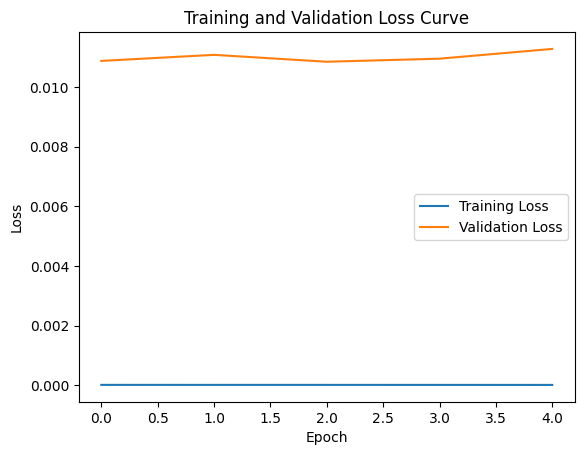

In [ ]:
# Train and save the model

model, history = train_my_model(model=model,
                                model_name=model_name,
                                train_input=[data_set["images_train"] ,aux_data["sequence_labels_train"][:,:-1], aux_data["sequence_labels_train"][:,-1:]], # needs to be changed, deppending on model Architekture
                                train_labels=data_set["labels_train"],
                                val_input=[data_set["images_validation"], aux_data["sequence_labels_validation"][:,:-1] ,aux_data["sequence_labels_validation"][:,-1:]],     # needs to be changed, deppending on model Architekture
                                val_labels=data_set["labels_validation"],
                                early_stopping_patience=2,
                                opti="Adam",  # Options: "Adam" or "SGD"
                                loss_function='mean_squared_error', # Options: 'mean_squared_error', 'mean_absolute_error'
                                )


# Evaluate the Model

In [5]:
# load a alredy traind model with wights:
model = load_my_model(model_name="FINAL MODELS/Test_Model_V17_New_split_70_15_15_days_BEST_MODEL")


In [ ]:
model.summary()

125/125 [==============================] - 4s 30ms/step
[-9.258918e-06] 0.0 0.0 0.0
[-9.258918e-06] 0.0 0.0 0.0
DL Model Metrics:
------------------
MAE: 0.643738210 W
MSE: 1.122934818 W^2
RMSE: 1.059686184 W
NRMSE: 29.581338167
NMAE: 0.002623902
R2: 0.999988587
MAPE: inf%
Relative RMSE: 0.004319322

SPM Model Metrics:
------------------
MAE: 1.419073462 W
MSE: 6.658201694 W^2
RMSE: 2.580349207 W
NRMSE: 0.172023277
NMAE: 0.005784199
R2: 0.999932328
MAPE: 0.711867493%
Relative RMSE: 0.010517605

PR Model Metrics:
------------------
MAE: 59.990951538 W
MSE: 10996.657226562 W^2
RMSE: 104.864944458 W
NRMSE: 6.990996748
NMAE: 0.244525462
R2: 0.888233451
MAPE: nan%
Relative RMSE: 0.427433610

Skill Score (DL Model vs SPM):
------------------
Skill Score: 58.932500000%

Skill Score (DL Model vs PR):
------------------
Skill Score: 98.989500000%

Skill Score (SPM Model vs PR):
------------------
Skill Score: 97.539400000%






<ipython-input-2-d03e1dc101c1>:597: RuntimeWarning: divide by zero encountered in divide
  mape_dl = round(np.mean(np.abs((test_labels_new - DL_predictions_new) / test_labels_new)) * 100, 9)
<ipython-input-2-d03e1dc101c1>:615: RuntimeWarning: divide by zero encountered in divide
  mape_pr = round(np.mean(np.abs((test_labels_new - PR_predictions_new) / test_labels_new)) * 100, 9)
<ipython-input-2-d03e1dc101c1>:615: RuntimeWarning: invalid value encountered in divide
  mape_pr = round(np.mean(np.abs((test_labels_new - PR_predictions_new) / test_labels_new)) * 100, 9)


Kurtosis und Skewness:
DL-Modell - Kurtosis: 1.7708514365948043, Skewness: 0.41958391941129275
SPM-Modell - Kurtosis: 7.0327827918715204, Skewness: -2.3904558611683724


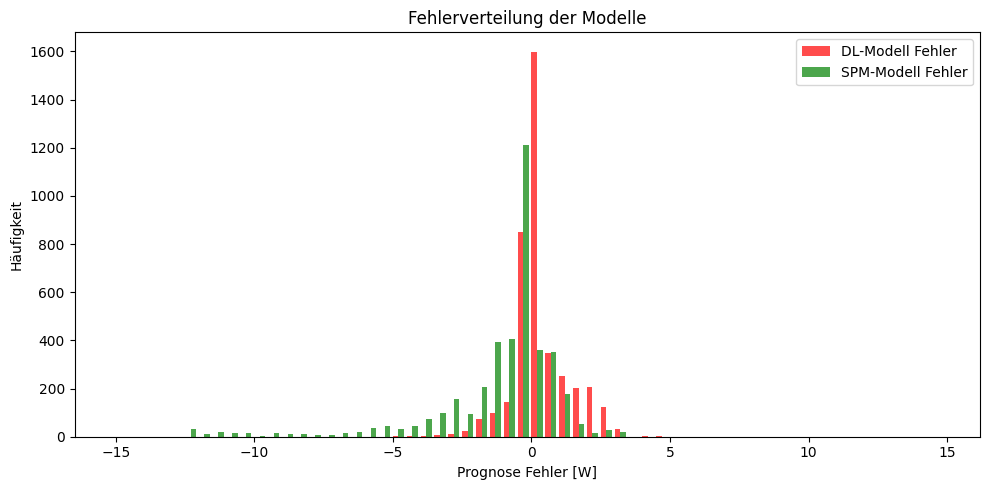

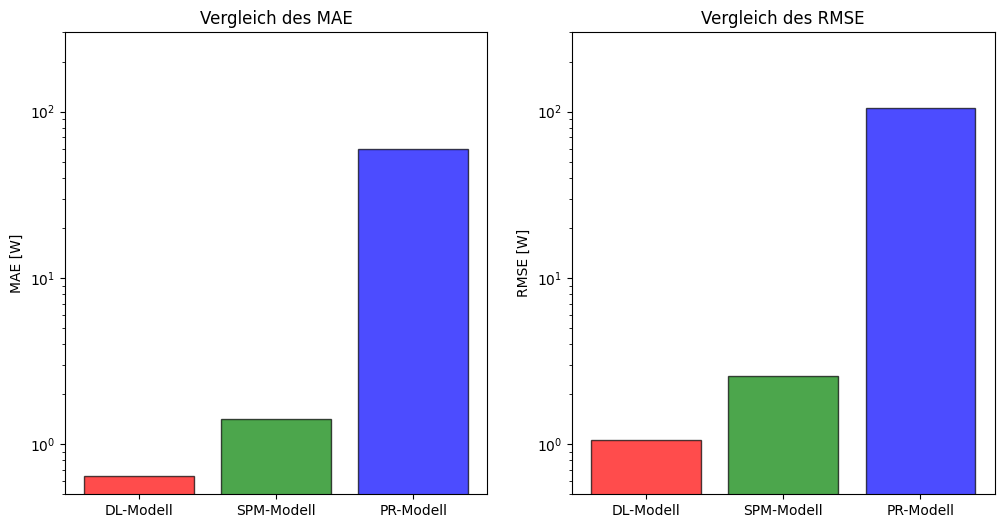

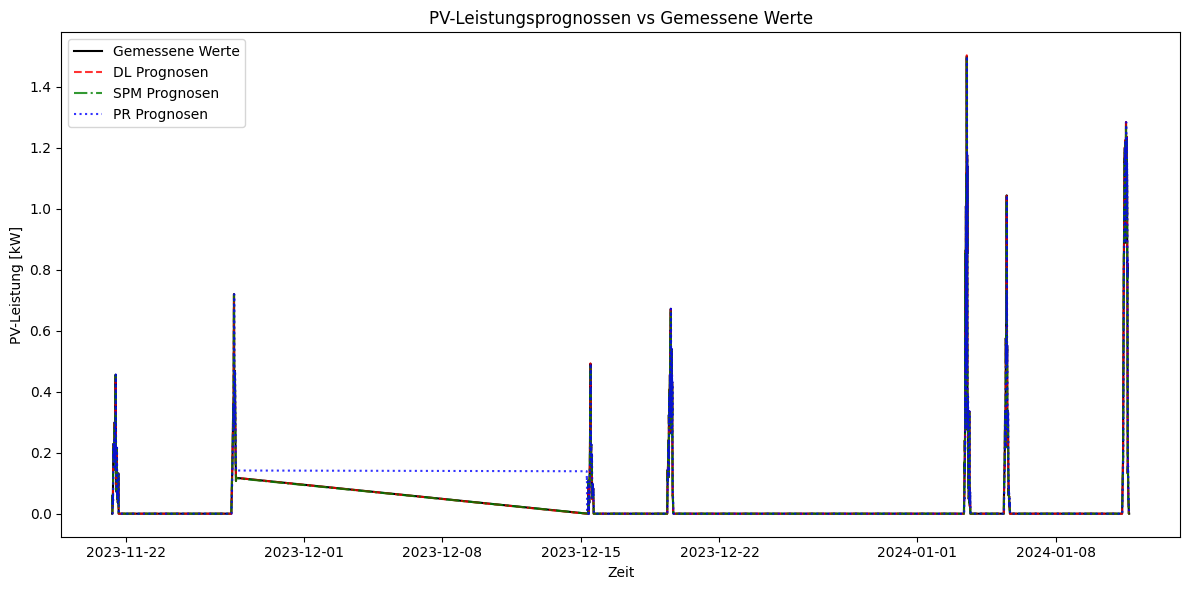

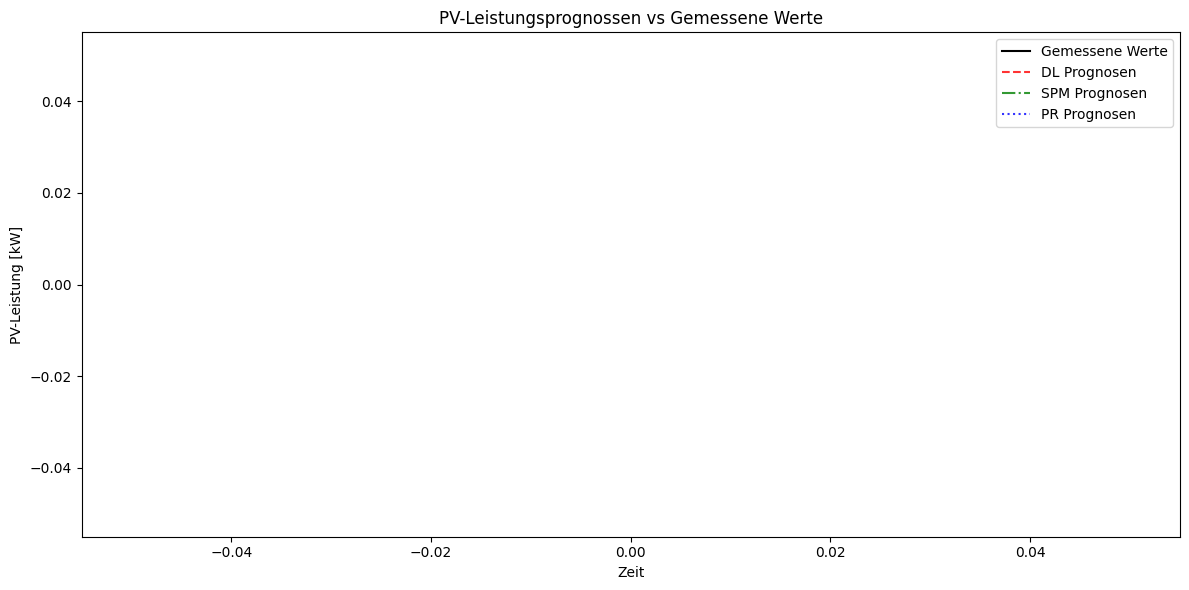

Modellplot 1 wurde in /content/drive/My Drive/BA/wights_and_Models/Temp_V3.2/plots/model_plot_1.png gespeichert.
Modellplot 2 wurde in /content/drive/My Drive/BA/wights_and_Models/Temp_V3.2/plots/model_plot_2.png gespeichert.
Modellplot 3 wurde in /content/drive/My Drive/BA/wights_and_Models/Temp_V3.2/plots/model_plot_3.png gespeichert.
Modellplot 4 wurde in /content/drive/My Drive/BA/wights_and_Models/Temp_V3.2/plots/model_plot_4.png gespeichert.


In [6]:
# Evaluieren des Modells mithilfe der Testdaten

#"preprozessed_data/Day_Split_70_15_15/smart_persistence_data"
#"preprozessed_data_SKIPPD/smart_persistence_data_Full"

start_timestamp = "2019-05-27 14:00:00"
end_timestamp = "2019-05-27 14:30:00"



evaluate_model_performance(model=model,
                           model_name=model_name,
                           test_input=[data_set["images_test"], aux_data["sequence_labels_test"][:,:-1] , aux_data["sequence_labels_test"][:,-1:]], # needs to be changed, deppending on model Architekture
                           test_labels=data_set["labels_test"],
                           test_timestamps=data_set["datetime_test"],
                           small_dataset=False,
                           spm_path="preprozessed_data/Day_Split_70_15_15/smart_persistence_data",
                           start_timestamp=start_timestamp,
                           end_timestamp=end_timestamp)



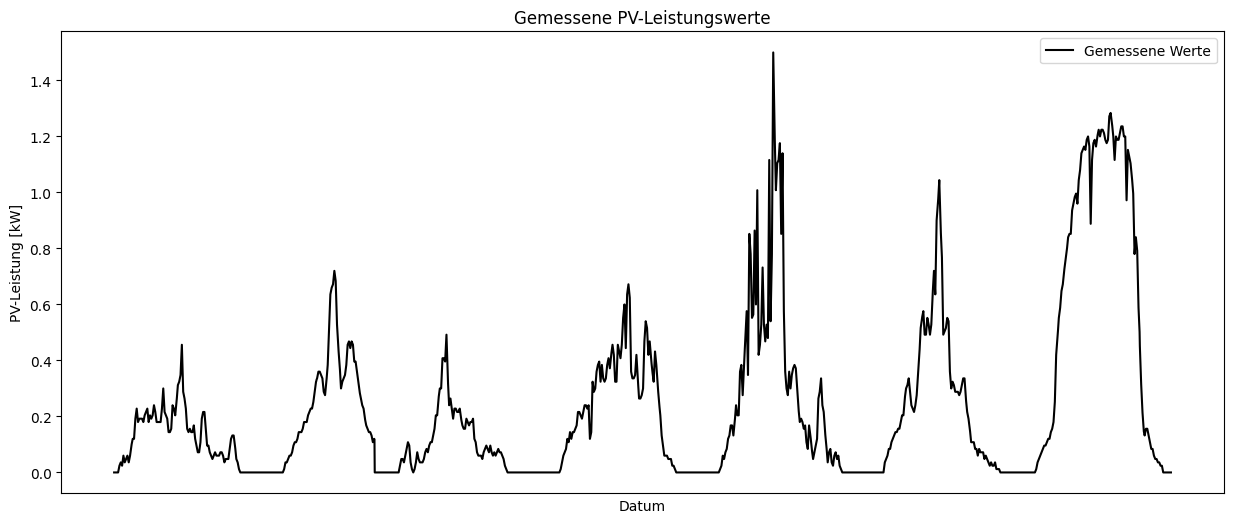

In [8]:
# Plot erstellen
plt.figure(figsize=(15, 6))  # Ändere die Größe des Plots nach Bedarf

# Daten plotten
sns.lineplot(data=data_set["labels_test"], label='Gemessene Werte', color='black', linewidth=1.5)

# X-Achse anpassen
plt.xticks([])  # Annahme: Jeder 600. Wert entspricht einem Tag

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel('Datum')
plt.ylabel('PV-Leistung [kW]')
plt.title('Gemessene PV-Leistungswerte')

# Legende anzeigen
plt.legend()

# Plot anzeigen
plt.show()

In [ ]:
def load_predictions_from_pkl(folder_path):
    """
    Lädt die gespeicherten Vorhersagen und Labels aus den PKL-Dateien.

    Parameters:
    folder_path (str): Der Pfad zum Ordner, in dem die PKL-Dateien gespeichert sind.

    Returns:
    tuple: Ein Tupel mit den geladenen Vorhersagen und Labels (DL_predictions, spm_predictions, PR_predictions, test_labels, test_timestamps).
    """
    DL_predictions = None
    spm_predictions = None
    PR_predictions = None
    test_labels = None
    test_timestamps = None

    # Überprüfe, ob der Ordner vorhanden ist
    if not os.path.exists(folder_path):
        raise FileNotFoundError("Der angegebene Ordner existiert nicht.")

    # Lade die Vorhersagen und Labels aus den PKL-Dateien
    try:
        with open(os.path.join(folder_path, 'DL_predictions.pkl'), 'rb') as f:
            DL_predictions = pickle.load(f)
        with open(os.path.join(folder_path, 'spm_predictions.pkl'), 'rb') as f:
            spm_predictions = pickle.load(f)
        with open(os.path.join(folder_path, 'PR_prediction.pkl'), 'rb') as f:
            PR_predictions = pickle.load(f)
        with open(os.path.join(folder_path, 'test_labels.pkl'), 'rb') as f:
            test_labels = pickle.load(f)
        with open(os.path.join(folder_path, 'test_timestamps.pkl'), 'rb') as f:
            test_timestamps = pickle.load(f)
    except Exception as e:
        print(f"Fehler beim Laden der PKL-Dateien: {e}")

    return DL_predictions, spm_predictions, PR_predictions, test_labels, test_timestamps

# Beispielaufruf der Funktion
folder_path = "/content/drive/My Drive/BA/wights_and_Models/Create_plots_temp1"
DL_predictions, spm_predictions, PR_predictions, test_labels, test_timestamps = load_predictions_from_pkl(folder_path)

In [9]:
def plot_pv_prediction_(test_labels, DL_predictions, spm_predictions, PR_predictions, test_timestamps, start_timestamp=None, end_timestamp=None):
    """
    Erstellt ein Seaborn-Diagramm mit Ground Truth Testlabels sowie Vorhersagen von DL-, SPM- und PR-Modellen.

    Parameters:
    test_labels (numpy.ndarray): Die Ground-Truth-Testlabels.
    DL_predictions (numpy.ndarray): Die Vorhersagen des DL-Modells.
    spm_predictions (numpy.ndarray): Die Vorhersagen des SPM-Modells.
    PR_predictions (numpy.ndarray): Die Vorhersagen des PR-Modells.
    test_timestamps (list): Die Zeitstempel der Testdaten.
    start_timestamp (str): Der Startzeitstempel für den Ausschnitt (optional).
    end_timestamp (str): Der Endzeitstempel für den Ausschnitt (optional).

    Returns:
    matplotlib.figure.Figure: Das Plot-Objekt.
    """

    # Daten vorbereiten
    data = {
        'Timestamps': test_timestamps,
        'Ground Truth': test_labels,
        'DL Predictions': DL_predictions.flatten(),
        'SPM Predictions': spm_predictions,
        'PR Predictions': PR_predictions.flatten()
    }

    # DataFrame erstellen
    df = pd.DataFrame(data)

    # Ausschnitt der Zeitstempel filtern
    if start_timestamp is not None and end_timestamp is not None:
        mask = (df['Timestamps'] >= start_timestamp) & (df['Timestamps'] <= end_timestamp)
        df_filtered = df.loc[mask]
    else:
        df_filtered = df


    # Diagramm erstellen
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_filtered[['Timestamps', 'Ground Truth']], x='Timestamps', y='Ground Truth', label='Gemessene Werte', color='black', linewidth=1.5)
    sns.lineplot(data=df_filtered[['Timestamps', 'DL Predictions']], x='Timestamps', y='DL Predictions', label='DL Prognosen', color='red', linestyle='--', alpha=0.8)
    sns.lineplot(data=df_filtered[['Timestamps', 'SPM Predictions']], x='Timestamps', y='SPM Predictions', label='SPM Prognosen', color='green', linestyle='-.', alpha=0.8)
    sns.lineplot(data=df_filtered[['Timestamps', 'PR Predictions']], x='Timestamps', y='PR Predictions', label='PR Prognosen', color='blue', linestyle=':', alpha=0.8)


    # Markierung der Datenpunkte im Ausschnitt
    #if start_timestamp is not None:
        #plt.scatter(df_filtered['Timestamps'], df_filtered['Ground Truth'], marker='.', color='black', label='measured data points')

    plt.xlabel('Zeit')
    plt.ylabel('PV-Leistung [kW]')
    plt.title('PV-Leistungsprognossen vs Gemessene Werte')
    plt.legend()
    plt.xticks()
    plt.tight_layout()
    return plt.gcf()  # Rückgabe des Figure-Objekts ohne plt.show()


start_timestamp = "2024-01-11 14:00:00"
end_timestamp = "2024-01-11 14:30:00"

# Plot anzeigen
plot = plot_pv_prediction_(data_set["labels_test"], DL_predictions, spm_predictions, PR_predictions, data_set["datetime_test"], start_timestamp=start_timestamp, end_timestamp=end_timestamp)
plot.show()


NameError: name 'DL_predictions' is not defined

2024-01-11 14:49:00
125/125 [==============================] - 3s 24ms/step


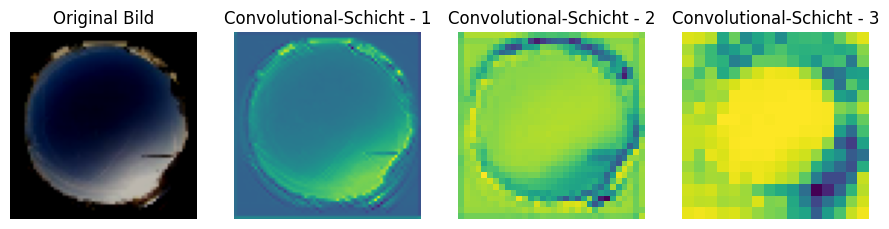

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

def visualize_feature_maps(model, layer_names, img_array):
    # Erstelle ein neues Modell, das nur bis zu den ausgewählten Schichten geht
    intermediate_layer_models = [Model(inputs=model.input, outputs=model.get_layer(name).output) for name in layer_names]

    # Erhalte die Ausgabe der gewünschten Schichten für das Originalbild
    original_outputs = [model.predict([np.expand_dims(img_array, axis=0),
                                      np.random.rand(16).reshape(1, -1),
                                      np.array([[1]])]) for model in intermediate_layer_models]

    # Erhalte die Ausgabe der gewünschten Schichten für das Originalbild
    intermediate_outputs = [model.predict([np.repeat(np.expand_dims(img_array, axis=0), len(data_set["images_test"]), axis=0),
                                           np.random.rand(len(data_set["images_test"]), 16),
                                           np.ones((len(data_set["images_test"]), 1))]) for model in intermediate_layer_models]

    # Anzahl der Feature-Maps in den ausgewählten Schichten
    num_filters_list = [output.shape[-1] for output in original_outputs]

    # Erstelle eine Grid-Anordnung der Feature-Maps für jede Schicht
    cols = sum(num_filters_list)  # Summe der Feature-Maps aller Schichten

    # Zeige das Originalbild und die Feature-Maps für jede Schicht
    plt.figure(figsize=(650, 250))

    # Zeige das Originalbild
    plt.subplot(1, cols + 1, 1)
    plt.imshow(img_array)
    plt.title('Original Bild')
    plt.axis('off')

    # Zeige die Feature-Maps für jede Schicht
    for k, (layer_name, num_filters) in enumerate(zip(layer_names, num_filters_list)):
        plt.subplot(1, cols + 1, k + 2)
        for i in range(num_filters):
            plt.imshow(intermediate_outputs[k][0, :, :, i], cmap='viridis')
        plt.title(f'Convolutional-Schicht - {k + 1}')
        plt.axis('off')

    plt.show()

# Layer-Namen auswählen (hier 3 Beispielnamen)
layer_names = ['conv2d', 'conv2d_1','conv2d_2']

# Lade ein Beispielbild
img_array = data_set["images_test"][3850]  # Nehmen Sie das erste Bild aus dem Datensatz
print(data_set["datetime_test"][3850])
# Visualisiere die Feature-Maps für die ausgewählten Schichten
visualize_feature_maps(model, layer_names, img_array)


125/125 [==============================] - 2s 19ms/step


<ipython-input-21-b879ced821e8>:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(layer_names)+1, num_filters, (k+1)*num_filters + filter_index + 2)


ValueError: num must be an integer with 1 <= num <= 768, not 769

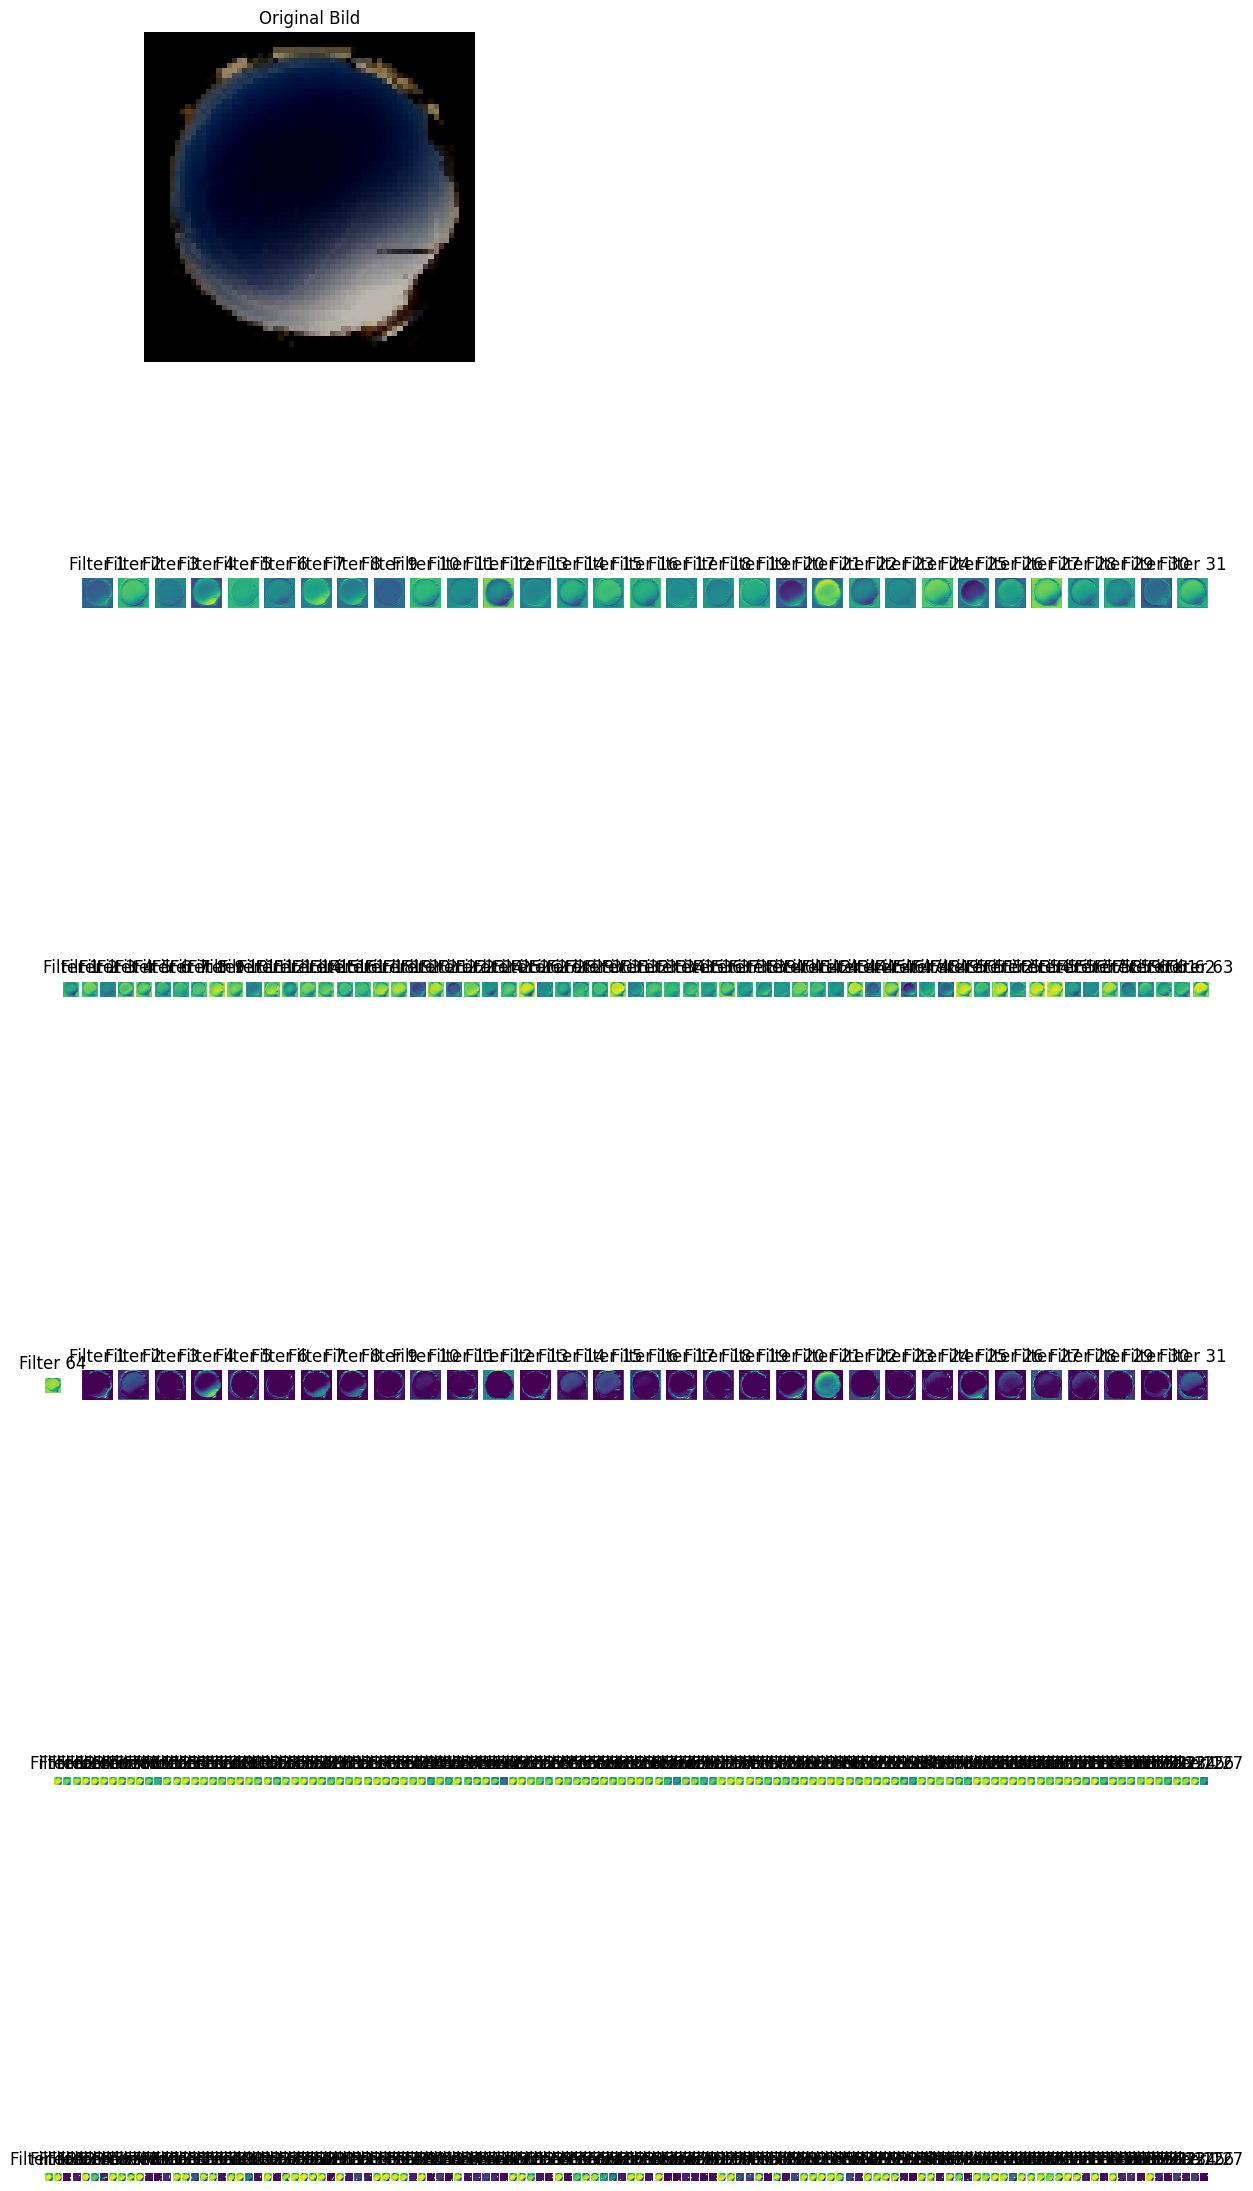

In [21]:
  import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

def visualize_feature_maps(model, layer_names, img_array):
    # Erstelle ein neues Modell, das nur bis zu den ausgewählten Schichten geht
    intermediate_layer_models = [Model(inputs=model.input, outputs=model.get_layer(name).output) for name in layer_names]

    # Erhalte die Ausgabe der gewünschten Schichten für das Originalbild
    original_outputs = [model.predict([np.expand_dims(img_array, axis=0),
                                      np.random.rand(16).reshape(1, -1),
                                      np.array([[1]])]) for model in intermediate_layer_models]

    # Erhalte die Ausgabe der gewünschten Schichten für das Originalbild
    intermediate_outputs = [model.predict([np.repeat(np.expand_dims(img_array, axis=0), len(data_set["images_test"]), axis=0),
                                           np.random.rand(len(data_set["images_test"]), 16),
                                           np.ones((len(data_set["images_test"]), 1))]) for model in intermediate_layer_models]

    # Anzahl der Feature-Maps in den ausgewählten Schichten
    num_filters_list = [output.shape[-1] for output in original_outputs]

    # Zeige das Originalbild und die Feature-Maps für jede Schicht
    plt.figure(figsize=(15, 5 + len(layer_names) * 5))

    # Zeige das Originalbild
    plt.subplot(len(layer_names)+1, 2, 1)
    plt.imshow(img_array)
    plt.title('Original Bild')
    plt.axis('off')

    # Zeige die Feature-Maps für jede Schicht
    for k, (layer_name, num_filters) in enumerate(zip(layer_names, num_filters_list)):
        for filter_index in range(num_filters):
            plt.subplot(len(layer_names)+1, num_filters, (k+1)*num_filters + filter_index + 2)
            plt.imshow(intermediate_outputs[k][:, :, :, filter_index].mean(axis=0), cmap='viridis')
            plt.title(f'Filter {filter_index+1}')
            plt.axis('off')

    plt.show()

# Layer-Namen auswählen (hier 3 Beispielnamen)
layer_names = ['conv2d', 'conv2d_1', "max_pooling2d" ,'conv2d_2', "max_pooling2d_2"]

# Lade ein Beispielbild
img_array = data_set["images_test"][3850]  # Nehmen Sie das erste Bild aus dem Datensatz

# Visualisiere die Feature-Maps für die ausgewählten Schichten
visualize_feature_maps(model, layer_names, img_array)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_model_output(model, sample_image, sample_PV_historie, sample_SPM, original_label):
    # Erstelle ein neues Modell, das nur bis zur Schicht dense_4 geht
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer('dense_4').output)

    # Berechne den Output von dense_4 für den ausgewählten Datenpunkt
    dense_4_output = intermediate_model.predict([sample_image.reshape(1, 64, 64, 3),
                                                 sample_PV_historie.reshape(1, 16), sample_SPM.reshape(1,)])

    # Extrahiere die Gewichte und den Bias von dense_5
    dense_5_weights, dense_5_bias = model.get_layer('dense_5').get_weights()

    # Berechne den Output von dense_5
    add_output = dense_4_output + sample_SPM
    dense_5_output = np.dot(add_output, dense_5_weights) + dense_5_bias

    # Print
    print('dense_4:', dense_4_output)
    print('input_SPM:', sample_SPM)
    print('add output:', add_output)
    print('Gewichte von dense_5 (w1, w2):', dense_5_weights)
    print('Bias von dense_5:', dense_5_bias)
    print('Output von dense_5:', dense_5_output)
    print('Label output:', original_label)

# Annahme: Das Modell heißt 'model' und die Testdaten sowie der Original-Label-Wert sind als Input gegeben
sample_image = data_set["images_test"][3700]
sample_PV_historie = aux_data["sequence_labels_test"][3700,:-1]
sample_SPM = aux_data["sequence_labels_test"][3700,-1:]
original_label = data_set["labels_test"][3700:3701]

visualize_model_output(model, sample_image, sample_PV_historie, sample_SPM, original_label)


1/1 [==============================] - 0s 117ms/step
dense_4: [[-0.0019177]]
input_SPM: [1.1866603]
add output: [[1.1847426]]
Gewichte von dense_5 (w1, w2): [[1.0078115]]
Bias von dense_5: [-0.00027882]
Output von dense_5: [[1.1937184]]
Label output: [1.1928]


(1,)
1/1 [==============================] - 0s 122ms/step
(1,) (1,) (1,)


<ipython-input-29-3127704246c9>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Labels', y='Values', data=data, palette=[color_original, color_sample_SPM, color_dense_4])


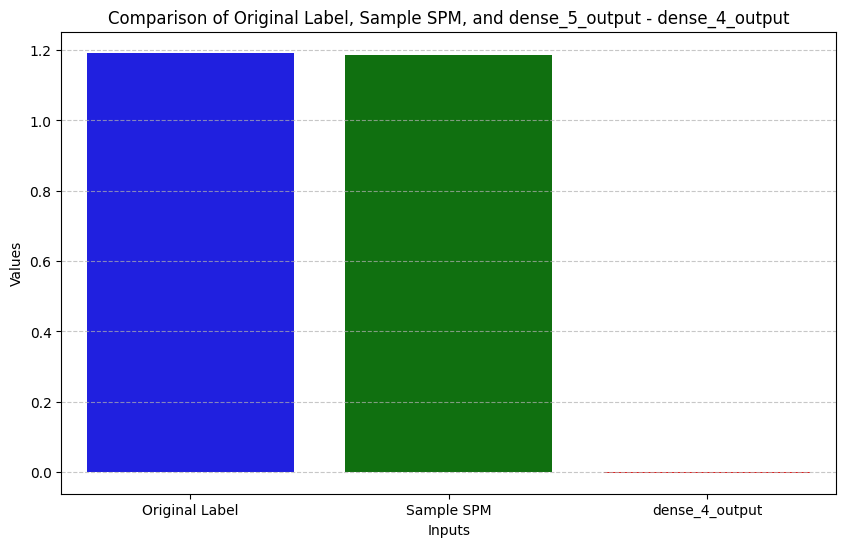

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Model

def visualize_model_output(model, sample_image, sample_PV_historie, sample_SPM, original_label):
    # Erstelle ein neues Modell, das nur bis zur Schicht dense_4 geht
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer('dense_4').output)

    # Berechne den Output von dense_4 für den ausgewählten Datenpunkt
    dense_4_output = intermediate_model.predict([sample_image.reshape(1, 64, 64, 3),
                                                 sample_PV_historie.reshape(1, 16), sample_SPM.reshape(1,)])

    # Extrahiere die Gewichte und den Bias von dense_5
    dense_5_weights, dense_5_bias = model.get_layer('dense_5').get_weights()

    # Berechne den Output von dense_5
    add_output = dense_4_output + sample_SPM
    dense_5_output = np.dot(add_output, dense_5_weights) + dense_5_bias

    # Extrahiere den Wert des originalen Labels
    #original_label_value = original_label.item()  # Convert array to scalar

    # Define labels, values, and colors separately
    label_original = 'Original Label'
    label_sample_SPM = 'Sample SPM'
    label_dense_4 = 'dense_4_output'

    value_original = original_label
    value_sample_SPM = sample_SPM
    value_dense_4 =  dense_4_output
    print(value_original.shape,value_sample_SPM.shape,value_dense_4[0].shape)
    color_original = 'blue'
    color_sample_SPM = 'green'
    color_dense_4 = 'red'

    # Create a DataFrame for plotting
    data = pd.DataFrame({
        'Labels': [label_original, label_sample_SPM, label_dense_4],
        'Values': np.concatenate([value_original, value_sample_SPM, value_dense_4[0]]),
        'Colors': [color_original, color_sample_SPM, color_dense_4]
    })

    # Plot the data
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Labels', y='Values', data=data, palette=[color_original, color_sample_SPM, color_dense_4])
    plt.xlabel('Inputs')
    plt.ylabel('Values')
    plt.title('Comparison of Original Label, Sample SPM, and dense_5_output - dense_4_output')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Annahme: Das Modell heißt 'model' und die Testdaten sowie der Original-Label-Wert sind als Input gegeben
sample_image = data_set["images_test"][3700]
sample_PV_historie = aux_data["sequence_labels_test"][3700,:-1]
sample_SPM = aux_data["sequence_labels_test"][3700,-1:]
original_label = data_set["labels_test"][3700:3701]  # DONT Remove slicing
print(sample_SPM.shape)
visualize_model_output(model, sample_image, sample_PV_historie, sample_SPM, original_label)


(5, 64, 64, 3) (5, 16) (5, 1) (5, 1)
1/1 [==============================] - 0s 30ms/step


ValueError: Unrecognized marker style '-'

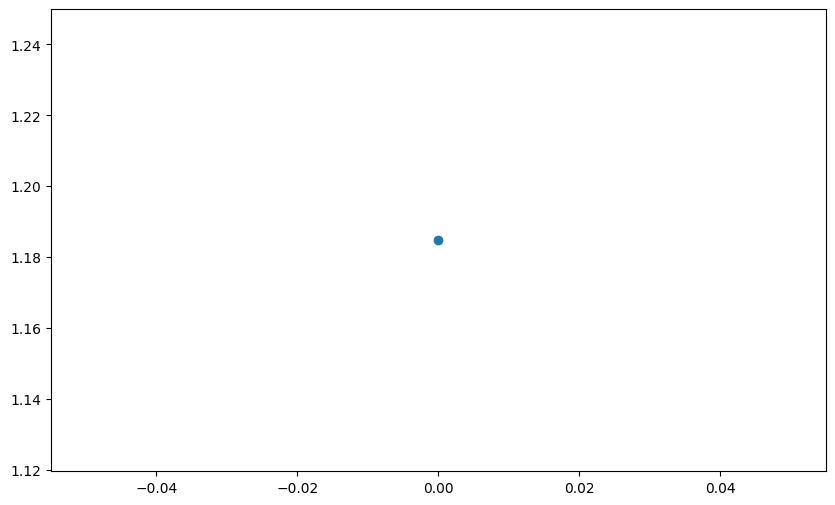

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Model

def visualize_model_output(model, sample_images, sample_PV_historie, sample_SPMs, original_labels):
    # Erstelle ein neues Modell, das nur bis zur Schicht dense_4 geht
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer('dense_4').output)

    # Berechne den Output von dense_4 für die ausgewählten Datenpunkte
    dense_4_outputs = []
    for i in range(len(sample_images)):
        dense_4_output = intermediate_model.predict([sample_images[i].reshape(1, 64, 64, 3),
                                                     sample_PV_historie[i].reshape(1, 16), sample_SPMs[i].reshape(1,)])
        dense_4_outputs.append(dense_4_output.flatten())  # Flach machen, um den gesamten Verlauf zu erhalten

    # Extrahiere die Gewichte und den Bias von dense_5
    dense_5_weights, dense_5_bias = model.get_layer('dense_5').get_weights()

    # Berechne den Output von dense_5 für die ausgewählten Datenpunkte
    add_outputs = []
    for i in range(len(sample_images)):
        add_output = dense_4_outputs[i] + sample_SPMs[i]
        add_outputs.append(add_output)

    dense_5_outputs = []
    for i in range(len(sample_images)):
        dense_5_output = np.dot(add_outputs[i], dense_5_weights) + dense_5_bias
        dense_5_outputs.append(dense_5_output)

    # Extrahiere die Werte der originalen Labels
    original_label_values = original_labels.flatten()

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(len(sample_images)):
        x = np.arange(len(dense_4_outputs[i]))  # Verwende den gleichen x-Bereich für alle Sample-Punkte
        y = add_outputs[i]
        plt.plot(x, y, label=f'Sample {i+1} SPM + dense_4_output', marker='o')
        plt.plot(x,original_label_values[i],label=f'Label', marker='-')

    plt.xlabel('Inputs')
    plt.ylabel('Values')
    plt.title('Comparison of Sample SPM + dense_4_output')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()





# Annahme: Das Modell heißt 'model' und die Testdaten sowie die Original-Label-Werte sind als Input gegeben
sample_images = data_set["images_test"][3700:3705]
sample_PV_historie = aux_data["sequence_labels_test"][3700:3705,:-1]
sample_SPMs = aux_data["sequence_labels_test"][3700:3705,-1:]
original_labels = data_set["labels_test"][3700:3705].reshape(5,1)

print(sample_images.shape,sample_PV_historie.shape,sample_SPMs.shape,original_labels.shape)

visualize_model_output(model, sample_images, sample_PV_historie, sample_SPMs, original_labels)


1/1 [==============================] - 0s 30ms/step


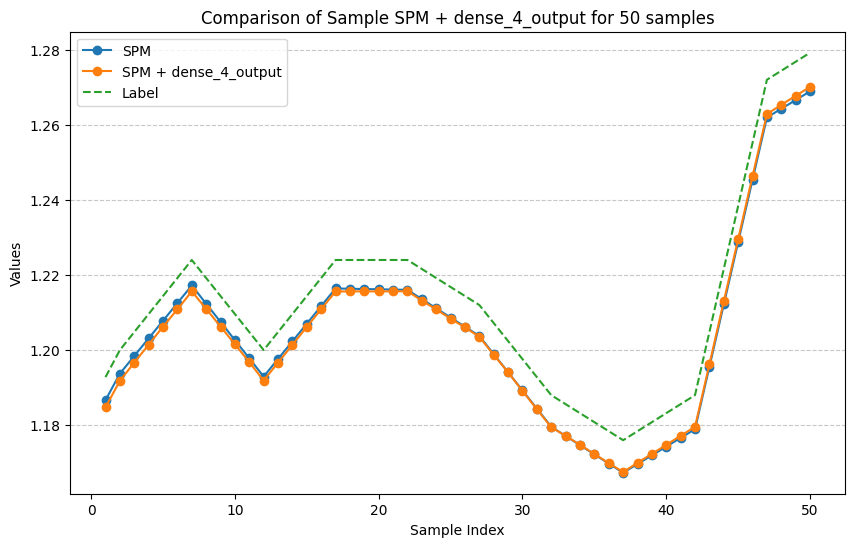

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_model_output(model, sample_images, sample_PV_historie, sample_SPMs, original_labels, num_samples):
    # Erstelle ein neues Modell, das nur bis zur Schicht dense_4 geht
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer('dense_4').output)

    # Extrahiere die Gewichte und den Bias von dense_5
    dense_5_weights, dense_5_bias = model.get_layer('dense_5').get_weights()

    # Initialisiere Arrays zur Speicherung der Plot-Daten
    x_values = []
    spm_outputs = []
    add_outputs = []
    dense_5_outputs = []

    # Berechne und sammle den Output für die ausgewählten Datenpunkte
    for i in range(num_samples):
        # Berechne den Output von dense_4 für den aktuellen Datenpunkt
        dense_4_output = intermediate_model.predict([sample_images[i].reshape(1, 64, 64, 3),
                                                     sample_PV_historie[i].reshape(1, 16), sample_SPMs[i].reshape(1,)])

        # Berechne den addierten Output von dense_4 und SPM
        add_output = dense_4_output.flatten() + sample_SPMs[i]

        # Berechne den Output von dense_5
        dense_5_output = np.dot(add_output, dense_5_weights) + dense_5_bias

        # Speichere die Plot-Daten
        x_values.append(i + 1)
        spm_outputs.append(sample_SPMs[i])
        add_outputs.append(add_output)
        dense_5_outputs.append(dense_5_output)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, spm_outputs, label='SPM', marker='o')
    plt.plot(x_values, add_outputs, label='SPM + dense_4_output', marker='o')
    plt.plot(x_values, original_labels[:num_samples], label='Label', linestyle='--')

    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title(f'Comparison of Sample SPM + dense_4_output for {num_samples} samples')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Annahme: Das Modell heißt 'model' und die Testdaten sowie die Original-Label-Werte sind als Input gegeben
num_samples = 50  # Anzahl der ausgewählten Proben
sample_images = data_set["images_test"][3700:3700 + num_samples]
sample_PV_historie = aux_data["sequence_labels_test"][3700:3700 + num_samples,:-1]
sample_SPMs = aux_data["sequence_labels_test"][3700:3700 + num_samples,-1:]
original_labels = data_set["labels_test"][3700:3700 + num_samples].reshape(num_samples, 1)

visualize_model_output(model, sample_images, sample_PV_historie, sample_SPMs, original_labels, num_samples)
